# 1 Introducción

- Este análisis está basado en los datos de Dataset **"Diabetes Health Indicators"** que se encuentra en [este enlace](https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset).

## 1.2 Importaciones

In [43]:
# Manejo de archivos, tiempo y advertencias
import os
import json
import hashlib
import warnings
from time import sleep
from datetime import datetime, timedelta

# NumPy y Pandas
import numpy as np
import pandas as pd

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Escalado
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# GridSearchCV, Pipeline y Validación
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.pipeline import Pipeline

# Métricas
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

# Resampling
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler

# Modelos clásicos de series temporales
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# Modelos de machine learning y clasificación
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor, AdaBoostClassifier
from xgboost import XGBClassifier, XGBRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor
import lightgbm as lgb
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB

# PyTorch (Alternativa a Keras/TensorFlow)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Guardado y carga de modelos
import joblib

# Evitar advertencias de convergencia en modelos
warnings.filterwarnings('ignore', category = ConvergenceWarning)

## 1.3 Declaración de funciones

### 1.3.1 informacion_dfs(df)

- Esta función recibe un dataframe y devuelve la suma total de los **nulos**, **cadenas vacias** y **nones** que pudiera contener el dataframe del que buscamos la información.

In [44]:
def informacion_dfs(df):
    datos_nulos = df.isnull().sum().sum()
    cadenas_vacias = df[df == ''].sum().sum()
    nones = df[df == 'None'].sum().sum()
    return f"El Dataframe contiene {int(datos_nulos)} nulos, {int(cadenas_vacias)} cadenas vacias y {int(nones)} 'nones'"

### 1.3.2 mostrar_rango_columnas(df)

- Con esta función obtengo el valor mínimo y máximo de cada columna del dataframe para obtener cual es que rango es mayor en cada columna.

In [45]:
def mostrar_rango_columnas(df):
    for columna in df.columns:
        rango_min = df[columna].min(),
        rango_max = df[columna].max()
        print(f"Columa: {columna}\nMínimo: {rango_min}, Máximo: {rango_max}\n")

### 1.3.3 mostrar_columna_diabetes(df, 'nombre columna diabetes')

In [46]:
def mostrar_columna_diabetes(df, columna_diabetes):
    total = df[columna_diabetes].value_counts()

    if len(total) == 3:
        print(f"Sin diabetes: {total[0]}")
        print(f"Prediabetes: {total[1]}")
        print(f"Con diabetes: {total[2]}")
    elif len(total) == 2:
        print(f"Sin diabetes: {total[0]}")
        print(f"Con prediabetes o  diabetes: {total[1]}")
    else:
        print(f"Columna {columna_diabetes} tiene una salida no esperada.")

## 2 EDA

- Por defecto, Pandas siempre muestra cierto número de columnas. Con **"display.max_colums"** hago que muestre todas las columnas y con **"display.max_colwidth"** ajusto el ancho máximo, para que Pandas no trunque la salida en las celdas largas.

In [47]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

### 2.01 Lectura dataframe "diabetes_012_health_indicators_BRFSS2015.csv"

In [48]:
path_csv1 = 'data/diabetes_012_health_indicators_BRFSS2015.csv'

df_1 = pd.read_csv(path_csv1)
df_1.head(10)

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0
5,0.0,1.0,1.0,1.0,25.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,2.0,0.0,1.0,10.0,6.0,8.0
6,0.0,1.0,0.0,1.0,30.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,14.0,0.0,0.0,9.0,6.0,7.0
7,0.0,1.0,1.0,1.0,25.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0,0.0,1.0,0.0,11.0,4.0,4.0
8,2.0,1.0,1.0,1.0,30.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,5.0,30.0,30.0,1.0,0.0,9.0,5.0,1.0
9,0.0,0.0,0.0,1.0,24.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,1.0,8.0,4.0,3.0


#### 2.01.01 Exploración df_1

In [49]:
diabetes_012 = df_1.copy()
diabetes_012.columns

Index(['Diabetes_012', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')

#### 2.01.02 Renombrar columnas dataframe "diabetes_012"

In [50]:
columnas_diabetes_012 = {
    'Diabetes_012': 'Diabetes',
    'HighBP': 'Hipertensión',
    'HighChol': 'Colesterol',
    'CholCheck': 'Análisis_colesterol',
    'BMI': 'IMC',
    'Smoker': 'Fumador',
    'Stroke': 'Ictus',
    'HeartDiseaseorAttack': 'Enfermedad_Cardiaca_Infarto',
    'PhysActivity': 'Actividad_física',
    'Fruits': 'Frutas',
    'Veggies': 'Verduras',
    'HvyAlcoholConsump': 'Consumo_alto_alcohol',
    'AnyHealthcare': 'Cuidado_médico',
    'NoDocbcCost': 'Motivos_económicos ',
    'GenHlth': 'Salud_general',
    'MentHlth': 'Salud_mental',
    'PhysHlth': 'Salud_física',
    'DiffWalk': 'Dificultad_caminar',
    'Sex': 'Sexo',
    'Age': 'Edad',
    'Education': 'Educación',
    'Income': 'Ingresos'
}

diabetes_012.rename(columns = columnas_diabetes_012, inplace = True)

diabetes_012.head(6)

,Diabetes,Hipertensión,Colesterol,Análisis_colesterol,IMC,Fumador,Ictus,Enfermedad_Cardiaca_Infarto,Actividad_física,Frutas,Verduras,Consumo_alto_alcohol,Cuidado_médico,Motivos_económicos,Salud_general,Salud_mental,Salud_física,Dificultad_caminar,Sexo,Edad,Educación,Ingresos
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0
5,0.0,1.0,1.0,1.0,25.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,2.0,0.0,1.0,10.0,6.0,8.0


#### 2.01.03 Información de rangos/valores que obtiene cada columna.

##### 
- LLamando a la función he conseguido saber que datos aportan cada columna de máximo y mínimo. 
- La mayoría de la columnas son booleanas:
    - Diabetes, Hipertensión, Colesterol, Análisis_colesterol, Fumador, Ictus, Enfermedad_Cardiaca_Infarto, Actividad_física, Frutas, Verduras, Consumo_alto_alcohol, Cuidado_médico, Motivos_económicos, Dificultad_caminar, Sexo.
- Sin embargo en una primera toma de contacto las siguientes columnas aportaban unos diferentes valores que quise investigar:
    - Salud_general, Salud_mental, Salud_física, Edad, Educación, Ingresos.
        - **IMC** nos da el Indice de masa corporal que se consigue a partir del peso y de la altura del encuestado. El valor mínimo hallado ha sido 12 y el máximo ha sido 98.
        - **Salud_general** y sus valores **1, 2, 3, 4, 5** aporta la percepción propia del encuestado sobre su "Salud general". Siendo **1** Excelente, **2** Muy buena, **3** Buena, **4** Regular y **5** Mala.
        - **Salud_mental** y su valor máximo de **30**, indica que en la encuesta realizada de la que se consiguó los datos, cuantos días de los últimos 30, la persona ha tenido una mala "Salud mental". Si la persona no tubo ningún día de salud mental la puntuación de dicha columna sería **0**.
        - **Salud_física** y su valor máximo de **30** indica cuántos días de los últimos 30 la persona encuestada reportó que su "Salusd física" no había sido buena (enfermedades, lesiones)...
        - **Edad** esta columna clasifica a las personas en **13** grupos de edad:
            - 1 = 18-24 años
            - 2 = 25-29 años
            - 3 = 30-34 años
            - 4 = 35-39 años
            - 5 = 40-44 años
            - 6 = 45-49 años
            - 7 = 50-54 años
            - 8 = 55-59 años
            - 9 = 60-64 años
            - 10 = 65-69 años
            - 11 = 70-74 años
            - 12 = 75-79 años
            - 13 = 80 años o más
        - **Educación** y sus valores **1, 2, 3, 4, 5 , 6** corresponden al nivel educativo de los encuestados, siendo **1** nunca asistió a la escuela, **2** grados 1 a 8 (Educación primaria), **3** grados 9 a 11 (parte de la educación secundaria), **4** grado 12 (graduado de secundaria), **5** universidad de 1 a 3 años (parte de la educación superior) y **6** universidad mmas de 4 años (grado de educación superior)
        - **Ingresos** informa del nivel de ingresos de los encuestados, siendo **1** el ingreso menor y **8** el nivel mas elevado de ingresos.

In [51]:
mostrar_rango_columnas(diabetes_012)

Columa: Diabetes
Mínimo: (0.0,), Máximo: 2.0

Columa: Hipertensión
Mínimo: (0.0,), Máximo: 1.0

Columa: Colesterol
Mínimo: (0.0,), Máximo: 1.0

Columa: Análisis_colesterol
Mínimo: (0.0,), Máximo: 1.0

Columa: IMC
Mínimo: (12.0,), Máximo: 98.0

Columa: Fumador
Mínimo: (0.0,), Máximo: 1.0

Columa: Ictus
Mínimo: (0.0,), Máximo: 1.0

Columa: Enfermedad_Cardiaca_Infarto
Mínimo: (0.0,), Máximo: 1.0

Columa: Actividad_física
Mínimo: (0.0,), Máximo: 1.0

Columa: Frutas
Mínimo: (0.0,), Máximo: 1.0

Columa: Verduras
Mínimo: (0.0,), Máximo: 1.0

Columa: Consumo_alto_alcohol
Mínimo: (0.0,), Máximo: 1.0

Columa: Cuidado_médico
Mínimo: (0.0,), Máximo: 1.0

Columa: Motivos_económicos 
Mínimo: (0.0,), Máximo: 1.0

Columa: Salud_general
Mínimo: (1.0,), Máximo: 5.0

Columa: Salud_mental
Mínimo: (0.0,), Máximo: 30.0

Columa: Salud_física
Mínimo: (0.0,), Máximo: 30.0

Columa: Dificultad_caminar
Mínimo: (0.0,), Máximo: 1.0

Columa: Sexo
Mínimo: (0.0,), Máximo: 1.0

Columa: Edad
Mínimo: (1.0,), Máximo: 13.0

In [52]:
diabetes_012['IMC'].describe()

count    253680.000000
mean         28.382364
std           6.608694
min          12.000000
25%          24.000000
50%          27.000000
75%          31.000000
max          98.000000
Name: IMC, dtype: float64

##### Estadísticas de la columna ""IMC

- Según la Organización Mundial de la Salud (OMS), los rangos en cuanto a esta columna son los siguientes:
    - 	Bajo peso: BMI < 18.5
	-	Peso normal: 18.5 ≤ BMI < 24.9
	-   Sobrepeso: 25 ≤ BMI < 29.9
	-   Obesidad (Grado 1): 30 ≤ BMI < 34.9
	-	Obesidad (Grado 2): 35 ≤ BMI < 39.9
	-	Obesidad (Grado 3): BMI ≥ 40

- Información adicional de la columna "IMC":
    - Análisis estadístico:
        - **Media**: 28.38, en promedio, los encuestados están en un rango de sobrepeso.
        - **Desviación estándar** 6.61 con datos muy dispersados y gran variedad de índices de masas corporales con valores alejados del promedio.
        - **Valores mínimos y máximos** 12 (posiblemente un peso bajo extremo) y 98 (posiblemente obesidad morbida severa).
            - **Cuartiles**:
                - **25% (Q1)**: El 25% de los encuestados tiene un índice de masa corporal por debajo de 24, lo que se considera dentro del rango de un peso normal.
                - **50% (Q2 - Mediana)**: El 50% tiene un IMC menor o igual a 27 (frontera entre peso normal y sobrepeso).
                - **75% (Q3)**: El 75% tiene un IMC de 31 o menos. El valor 31 entra en el rango de obesidad.
        - Estas estadísticas muestran que una gran parter de los encuestados tienen un IMC con rango de sobrepeso/obesidad.

#### 2.01.04 Información Dataframe

- LLamada a la función para saber si el dataframe contiene nulos, cadenas vacias y nones y en caso de que así sea, cuantos hay.

In [53]:
informacion_dfs(diabetes_012)

"El Dataframe contiene 0 nulos, 0 cadenas vacias y 0 'nones'"

- Llamada a función para saber el total de valores de cada clase en la columna de "Diabetes"

In [54]:
mostrar_columna_diabetes(diabetes_012, 'Diabetes')

Sin diabetes: 213703
Prediabetes: 4631
Con diabetes: 35346


### 2.02 Lectura dataframe "diabetes_binary_5050split_health_indicators_BRFSS2015.csv"

In [55]:
path_csv2 = 'data/diabetes_binary_5050split_health_indicators_BRFSS2015.csv'

df_2 = pd.read_csv(path_csv2)
df_2.head(10)

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,3.0,5.0,30.0,0.0,1.0,4.0,6.0,8.0
1,0.0,1.0,1.0,1.0,26.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,1.0,12.0,6.0,8.0
2,0.0,0.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,10.0,0.0,1.0,13.0,6.0,8.0
3,0.0,1.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,3.0,0.0,3.0,0.0,1.0,11.0,6.0,8.0
4,0.0,0.0,0.0,1.0,29.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0
5,0.0,0.0,0.0,1.0,18.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,2.0,7.0,0.0,0.0,0.0,1.0,4.0,7.0
6,0.0,0.0,1.0,1.0,26.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,13.0,5.0,6.0
7,0.0,0.0,0.0,1.0,31.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,4.0,0.0,0.0,0.0,1.0,6.0,4.0,3.0
8,0.0,0.0,0.0,1.0,32.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,3.0,6.0,8.0
9,0.0,0.0,0.0,1.0,27.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,3.0,0.0,6.0,0.0,1.0,6.0,4.0,4.0


#### 2.02.01 Exploración df_2

In [56]:
binary_5050 = df_2.copy()
binary_5050.columns

Index(['Diabetes_binary', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')

#### 2.02.02 Renombrar columnas dataframe "binary_5050"

In [57]:
columnas_binary_5050 = {
    'Diabetes_binary': 'Diabetes_binaria',
    'HighBP': 'Hipertensión',
    'HighChol': 'Colesterol',
    'CholCheck': 'Análisis_colesterol',
    'BMI': 'IMC',
    'Smoker': 'Fumador',
    'Stroke': 'Ictus',
    'HeartDiseaseorAttack': 'Enfermedad_Cardiaca_Infarto',
    'PhysActivity': 'Actividad_física',
    'Fruits': 'Frutas',
    'Veggies': 'Verduras',
    'HvyAlcoholConsump': 'Consumo_alto_alcohol',
    'AnyHealthcare': 'Cuidado_médico',
    'NoDocbcCost': 'Motivos_económicos ',
    'GenHlth': 'Salud_general',
    'MentHlth': 'Salud_mental',
    'PhysHlth': 'Salud_física',
    'DiffWalk': 'Dificultad_caminar',
    'Sex': 'Sexo',
    'Age': 'Edad',
    'Education': 'Educación',
    'Income': 'Ingresos'
}

binary_5050.rename(columns = columnas_binary_5050, inplace = True)

binary_5050

,Diabetes_binaria,Hipertensión,Colesterol,Análisis_colesterol,IMC,Fumador,Ictus,Enfermedad_Cardiaca_Infarto,Actividad_física,Frutas,Verduras,Consumo_alto_alcohol,Cuidado_médico,Motivos_económicos,Salud_general,Salud_mental,Salud_física,Dificultad_caminar,Sexo,Edad,Educación,Ingresos
0,0.0,1.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,3.0,5.0,30.0,0.0,1.0,4.0,6.0,8.0
1,0.0,1.0,1.0,1.0,26.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,1.0,12.0,6.0,8.0
2,0.0,0.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,10.0,0.0,1.0,13.0,6.0,8.0
3,0.0,1.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,3.0,0.0,3.0,0.0,1.0,11.0,6.0,8.0
4,0.0,0.0,0.0,1.0,29.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70687,1.0,0.0,1.0,1.0,37.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0,6.0,4.0,1.0
70688,1.0,0.0,1.0,1.0,29.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,1.0,1.0,10.0,3.0,6.0
70689,1.0,1.0,1.0,1.0,25.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,5.0,15.0,0.0,1.0,0.0,13.0,6.0,4.0
70690,1.0,1.0,1.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,0.0,0.0,1.0,0.0,11.0,2.0,4.0


#### 2.02.03 Información de rangos/valores que obtiene cada columna.

##### 
- En este segundo dataframe **binary_5050** se mantiene la misma estructura que en el anterior, a excepción de la columna **"Diabetes"** que en este dataframe es también una salida binaria. Así como en el anterior había tres opciones de salida (sin diabetes, prediabetes y con diabetes), en esta se reduce a solo si o no. El resto de columnas se mantiene con los mismos criterios de medicción. El equilibrio de datos de este dataframe en relación a la columna diabetes de un 50% de cada opción. Es un dataframe perfectamente balanceado.

In [58]:
mostrar_rango_columnas(binary_5050)

Columa: Diabetes_binaria
Mínimo: (0.0,), Máximo: 1.0

Columa: Hipertensión
Mínimo: (0.0,), Máximo: 1.0

Columa: Colesterol
Mínimo: (0.0,), Máximo: 1.0

Columa: Análisis_colesterol
Mínimo: (0.0,), Máximo: 1.0

Columa: IMC
Mínimo: (12.0,), Máximo: 98.0



Columa: Fumador
Mínimo: (0.0,), Máximo: 1.0

Columa: Ictus
Mínimo: (0.0,), Máximo: 1.0

Columa: Enfermedad_Cardiaca_Infarto
Mínimo: (0.0,), Máximo: 1.0

Columa: Actividad_física
Mínimo: (0.0,), Máximo: 1.0

Columa: Frutas
Mínimo: (0.0,), Máximo: 1.0

Columa: Verduras
Mínimo: (0.0,), Máximo: 1.0

Columa: Consumo_alto_alcohol
Mínimo: (0.0,), Máximo: 1.0

Columa: Cuidado_médico
Mínimo: (0.0,), Máximo: 1.0

Columa: Motivos_económicos 
Mínimo: (0.0,), Máximo: 1.0

Columa: Salud_general
Mínimo: (1.0,), Máximo: 5.0

Columa: Salud_mental
Mínimo: (0.0,), Máximo: 30.0

Columa: Salud_física
Mínimo: (0.0,), Máximo: 30.0

Columa: Dificultad_caminar
Mínimo: (0.0,), Máximo: 1.0

Columa: Sexo
Mínimo: (0.0,), Máximo: 1.0

Columa: Edad
Mínimo: (1.0,), Máximo: 13.0

Columa: Educación
Mínimo: (1.0,), Máximo: 6.0

Columa: Ingresos
Mínimo: (1.0,), Máximo: 8.0



In [59]:
mostrar_columna_diabetes(binary_5050, 'Diabetes_binaria')

Sin diabetes: 35346
Con prediabetes o  diabetes: 35346


- Datos balanceados.

### 2.03 Lectura dataframe "diabetes_binary_health_indicators_BRFSS2015.csv"

In [60]:
path_csv3 = 'data/diabetes_binary_health_indicators_BRFSS2015.csv'

df_3 = pd.read_csv(path_csv3)
df_3.head(10)

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0
5,0.0,1.0,1.0,1.0,25.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,2.0,0.0,1.0,10.0,6.0,8.0
6,0.0,1.0,0.0,1.0,30.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,14.0,0.0,0.0,9.0,6.0,7.0
7,0.0,1.0,1.0,1.0,25.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0,0.0,1.0,0.0,11.0,4.0,4.0
8,1.0,1.0,1.0,1.0,30.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,5.0,30.0,30.0,1.0,0.0,9.0,5.0,1.0
9,0.0,0.0,0.0,1.0,24.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,1.0,8.0,4.0,3.0


#### 2.03.01 Exploración df_3

In [61]:
binary_health_indicators = df_3.copy()
binary_health_indicators.columns

Index(['Diabetes_binary', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')

#### 2.03.02 Renombrar columnas dataframe "binary_health_indicators"

In [62]:
columnas_indicadores_binary_health_indicators = {
    'Diabetes_binary': 'Diabetes_Binaria_IS',
    'HighBP': 'Hipertensión',
    'HighChol': 'Colesterol',
    'CholCheck': 'Análisis_colesterol',
    'BMI': 'IMC',
    'Smoker': 'Fumador',
    'Stroke': 'Ictus',
    'HeartDiseaseorAttack': 'Enfermedad_Cardiaca_Infarto',
    'PhysActivity': 'Actividad_física',
    'Fruits': 'Frutas',
    'Veggies': 'Verduras',
    'HvyAlcoholConsump': 'Consumo_alto_alcohol',
    'AnyHealthcare': 'Cuidado_médico',
    'NoDocbcCost': 'Motivos_económicos ',
    'GenHlth': 'Salud_general',
    'MentHlth': 'Salud_mental',
    'PhysHlth': 'Salud_física',
    'DiffWalk': 'Dificultad_caminar',
    'Sex': 'Sexo',
    'Age': 'Edad',
    'Education': 'Educación',
    'Income': 'Ingresos'
}

binary_health_indicators.rename(columns = columnas_indicadores_binary_health_indicators, inplace = True)

binary_health_indicators

,Diabetes_Binaria_IS,Hipertensión,Colesterol,Análisis_colesterol,IMC,Fumador,Ictus,Enfermedad_Cardiaca_Infarto,Actividad_física,Frutas,Verduras,Consumo_alto_alcohol,Cuidado_médico,Motivos_económicos,Salud_general,Salud_mental,Salud_física,Dificultad_caminar,Sexo,Edad,Educación,Ingresos
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,0.0,1.0,1.0,1.0,45.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,3.0,0.0,5.0,0.0,1.0,5.0,6.0,7.0
253676,1.0,1.0,1.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,0.0,0.0,1.0,0.0,11.0,2.0,4.0
253677,0.0,0.0,0.0,1.0,28.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,5.0,2.0
253678,0.0,1.0,0.0,1.0,23.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,1.0,7.0,5.0,1.0


#### 2.03.03 Información de rangos/valores que obtiene cada columna.

##### 
- En este tercer dataframe **binary_health_indicators** se mantiene la misma estructura que en el anterior. A diferencia del segundo dataframe **"binary_5050"**, con los datos perfectamente equilibrados, este dataframe no los contiene balanceados. La clase mayoritaria es "0, no diabetes".

In [63]:
mostrar_rango_columnas(binary_health_indicators)

Columa: Diabetes_Binaria_IS
Mínimo: (0.0,), Máximo: 1.0

Columa: Hipertensión
Mínimo: (0.0,), Máximo: 1.0

Columa: Colesterol
Mínimo: (0.0,), Máximo: 1.0

Columa: Análisis_colesterol
Mínimo: (0.0,), Máximo: 1.0

Columa: IMC
Mínimo: (12.0,), Máximo: 98.0

Columa: Fumador
Mínimo: (0.0,), Máximo: 1.0

Columa: Ictus
Mínimo: (0.0,), Máximo: 1.0

Columa: Enfermedad_Cardiaca_Infarto
Mínimo: (0.0,), Máximo: 1.0

Columa: Actividad_física
Mínimo: (0.0,), Máximo: 1.0

Columa: Frutas
Mínimo: (0.0,), Máximo: 1.0

Columa: Verduras
Mínimo: (0.0,), Máximo: 1.0

Columa: Consumo_alto_alcohol
Mínimo: (0.0,), Máximo: 1.0

Columa: Cuidado_médico
Mínimo: (0.0,), Máximo: 1.0

Columa: Motivos_económicos 
Mínimo: (0.0,), Máximo: 1.0

Columa: Salud_general
Mínimo: (1.0,), Máximo: 5.0

Columa: Salud_mental
Mínimo: (0.0,), Máximo: 30.0

Columa: Salud_física
Mínimo: (0.0,), Máximo: 30.0

Columa: Dificultad_caminar
Mínimo: (0.0,), Máximo: 1.0

Columa: Sexo
Mínimo: (0.0,), Máximo: 1.0

Columa: Edad
Mínimo: (1.0,), M

#### 2.03.04 Información Dataframe

- LLamada a la función para saber si el dataframe contiene nulos, cadenas vacias y nones y en caso de que así sea, cuantos hay.

In [64]:
informacion_dfs(binary_health_indicators)

"El Dataframe contiene 0 nulos, 0 cadenas vacias y 0 'nones'"

In [65]:
mostrar_columna_diabetes(binary_health_indicators, 'Diabetes_Binaria_IS')

Sin diabetes: 218334
Con prediabetes o  diabetes: 35346


- La clase mayoritaria en este dataframe para la columna diabetes es 0. Datos muy desbalanceados.

## 3 Gráficas

### 3.01.01 "diabetes_012"
- Este primer dataframe **"diabetes_012"** contiene las respuestas de los encuestados y su clase "Diabetes" se divide en tres salidas (0, 1, 2).

#### 3.01.01.01
- Histográma para todas las columnas del dataframe.

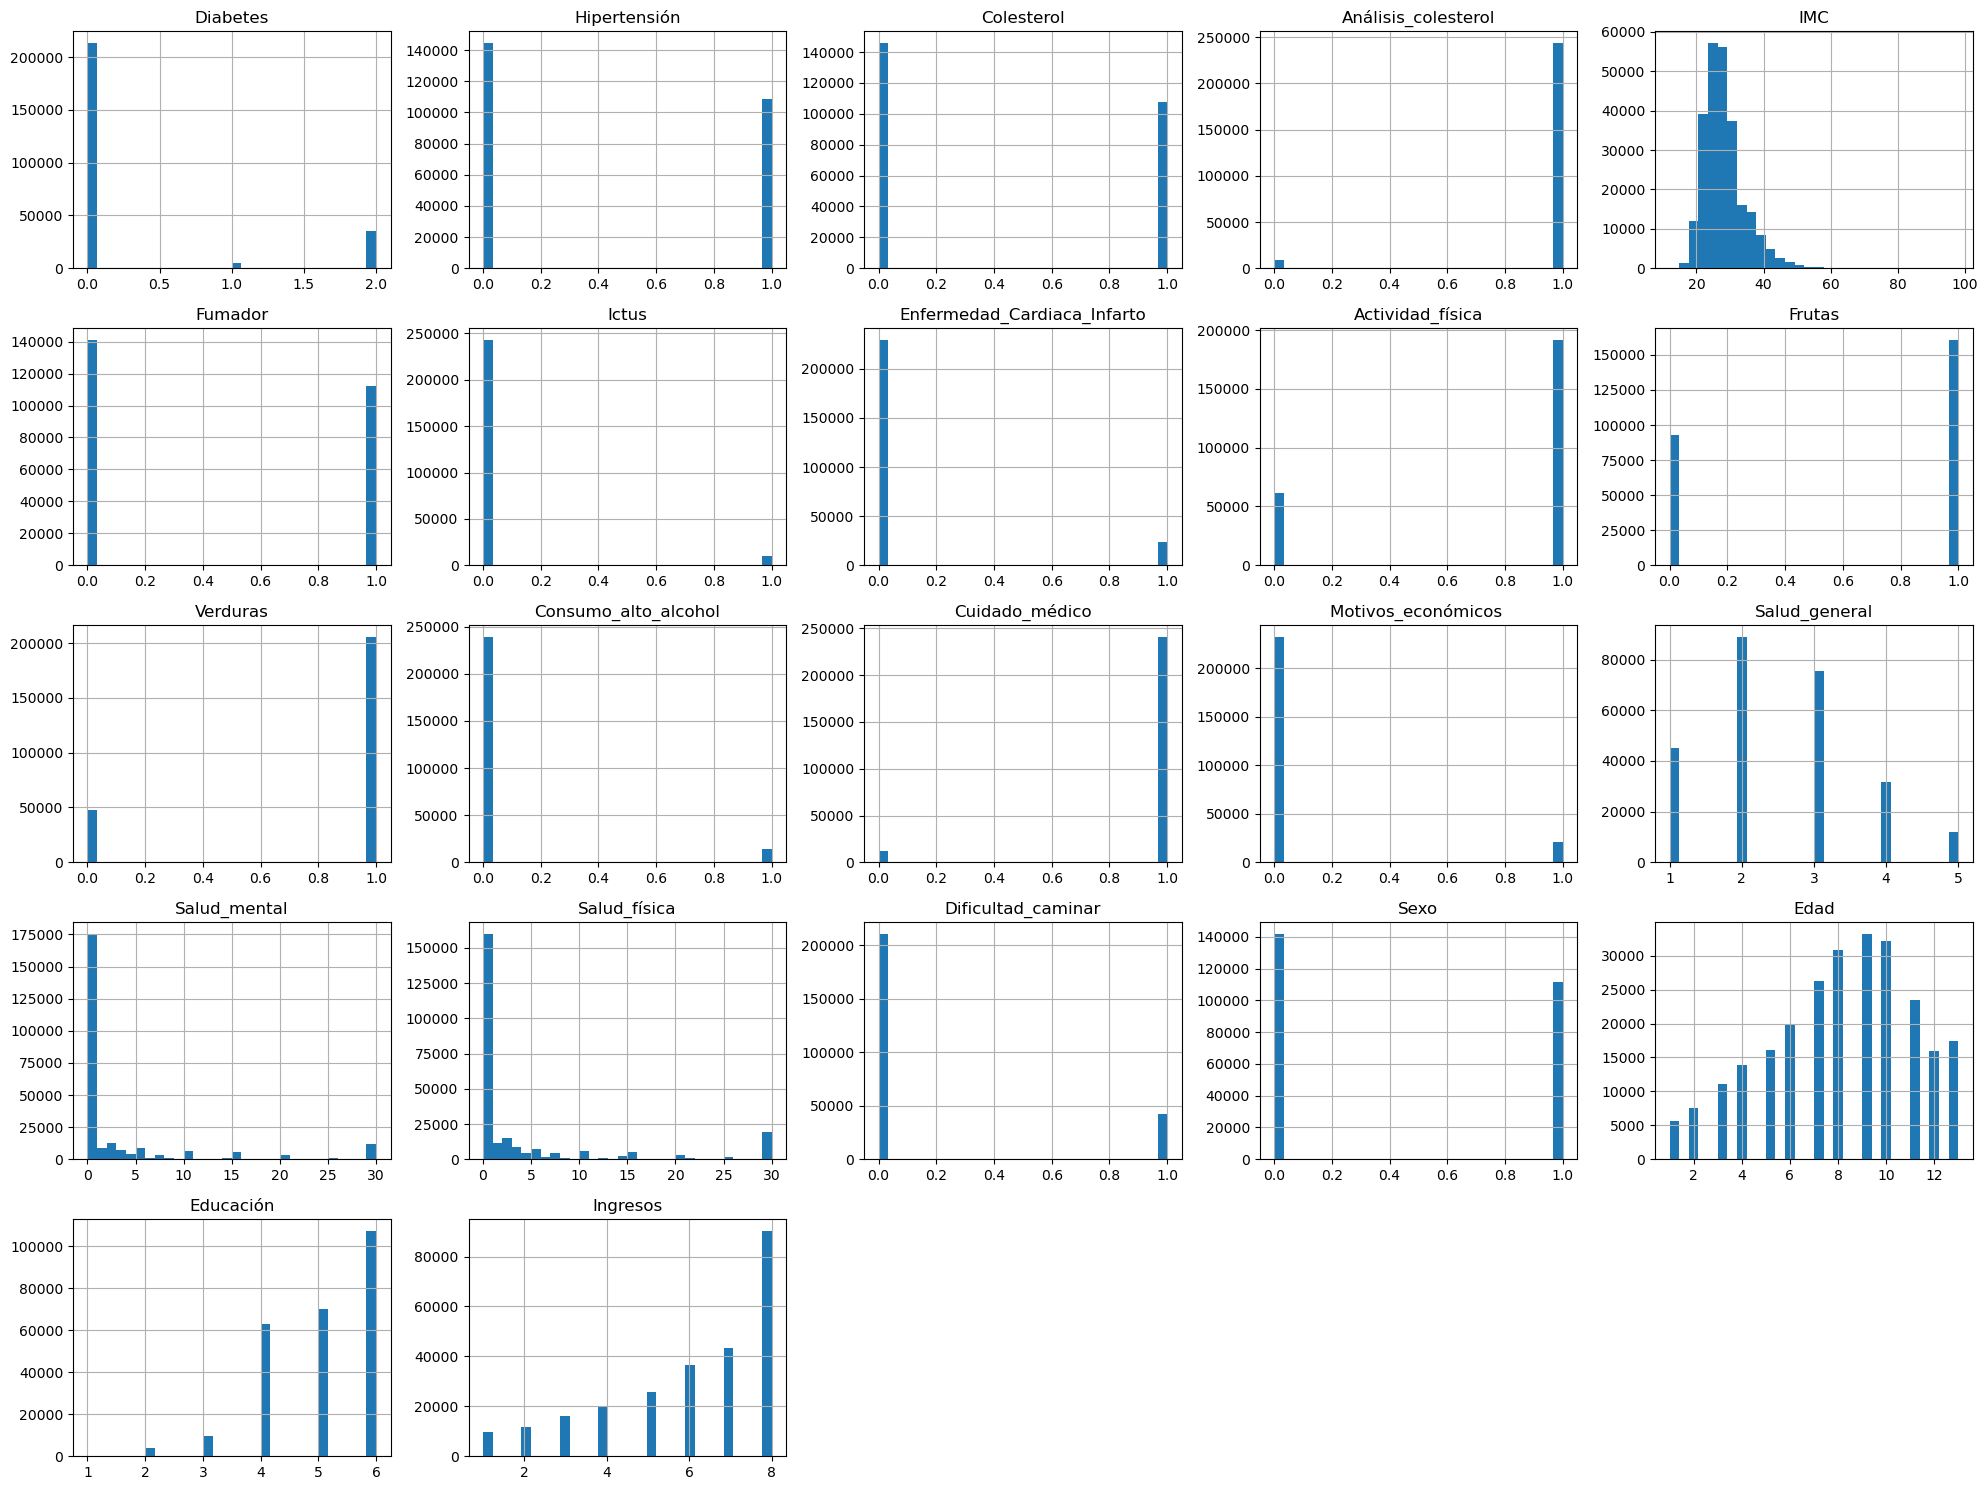

In [66]:
diabetes_012.hist(bins = 30, figsize = (20, 15))
plt.tight_layout()
plt.show()

#### 3.01.01.02 Matriz de correlación de Pearson del dataframe <u>diabetes_012</u>

### 3.01.02 "binary_5050"
- Histográma del segundo dataframe que contiene los datos balanceados en un cincuenta por cierto y se divide en **"sin y con diabetes"**.

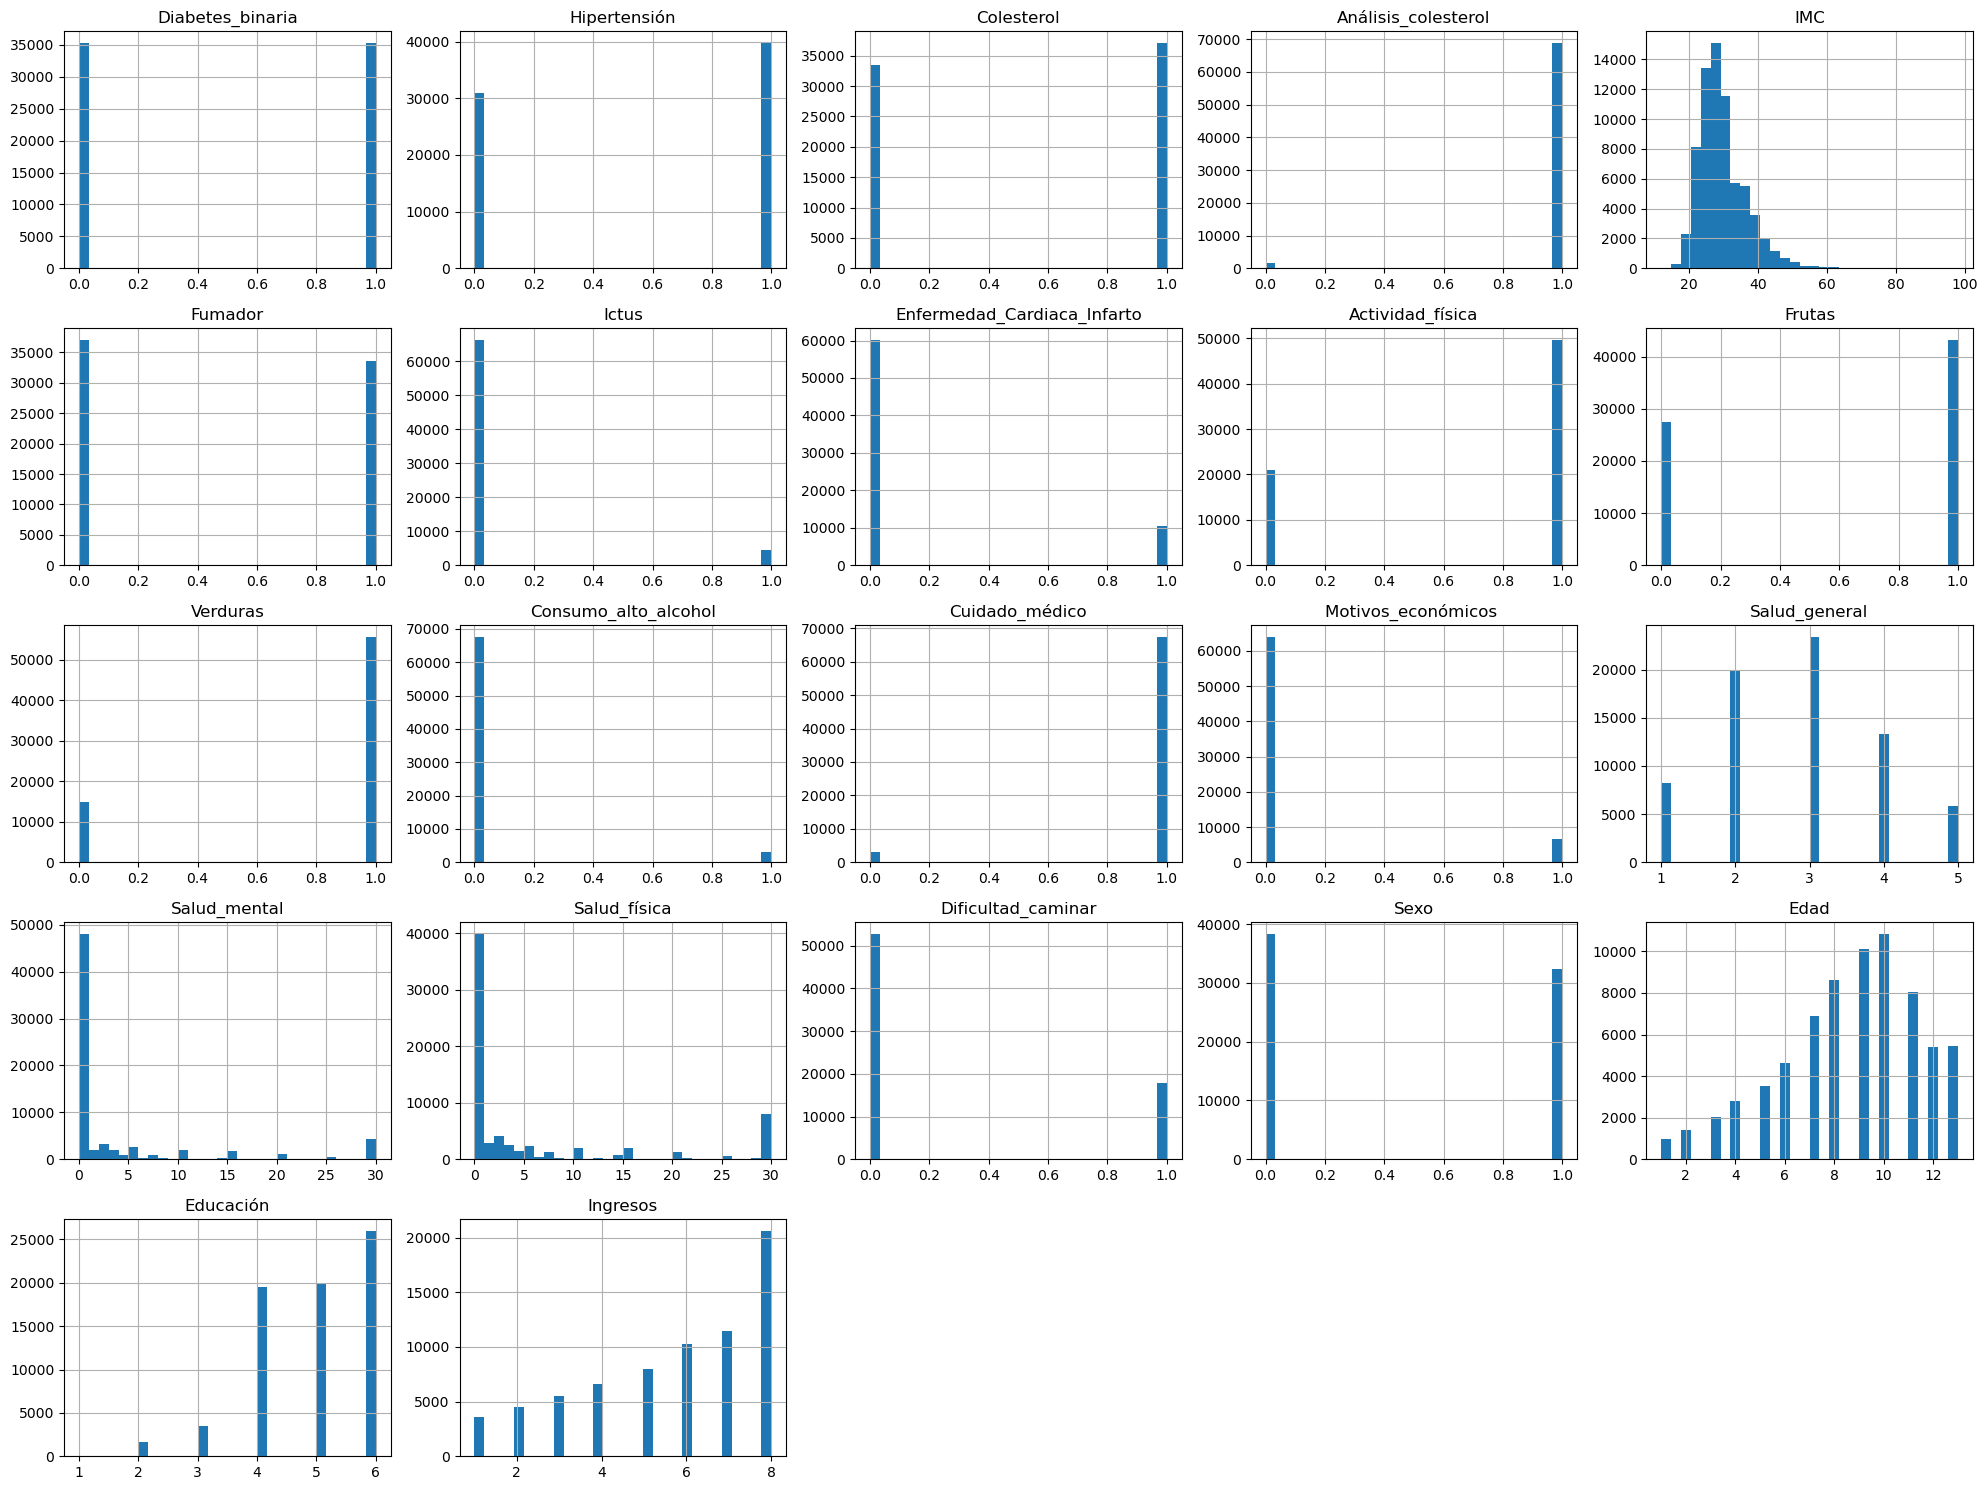

In [67]:
binary_5050.hist(bins = 30, figsize = (20,15))
plt.tight_layout()
plt.show()

### 3.01.03 "binary_health_indicators"
- Histográma del tercer dataframe que contiene los datos muy desbalanceados y su clase mayoriaria es **sin diabetes**.

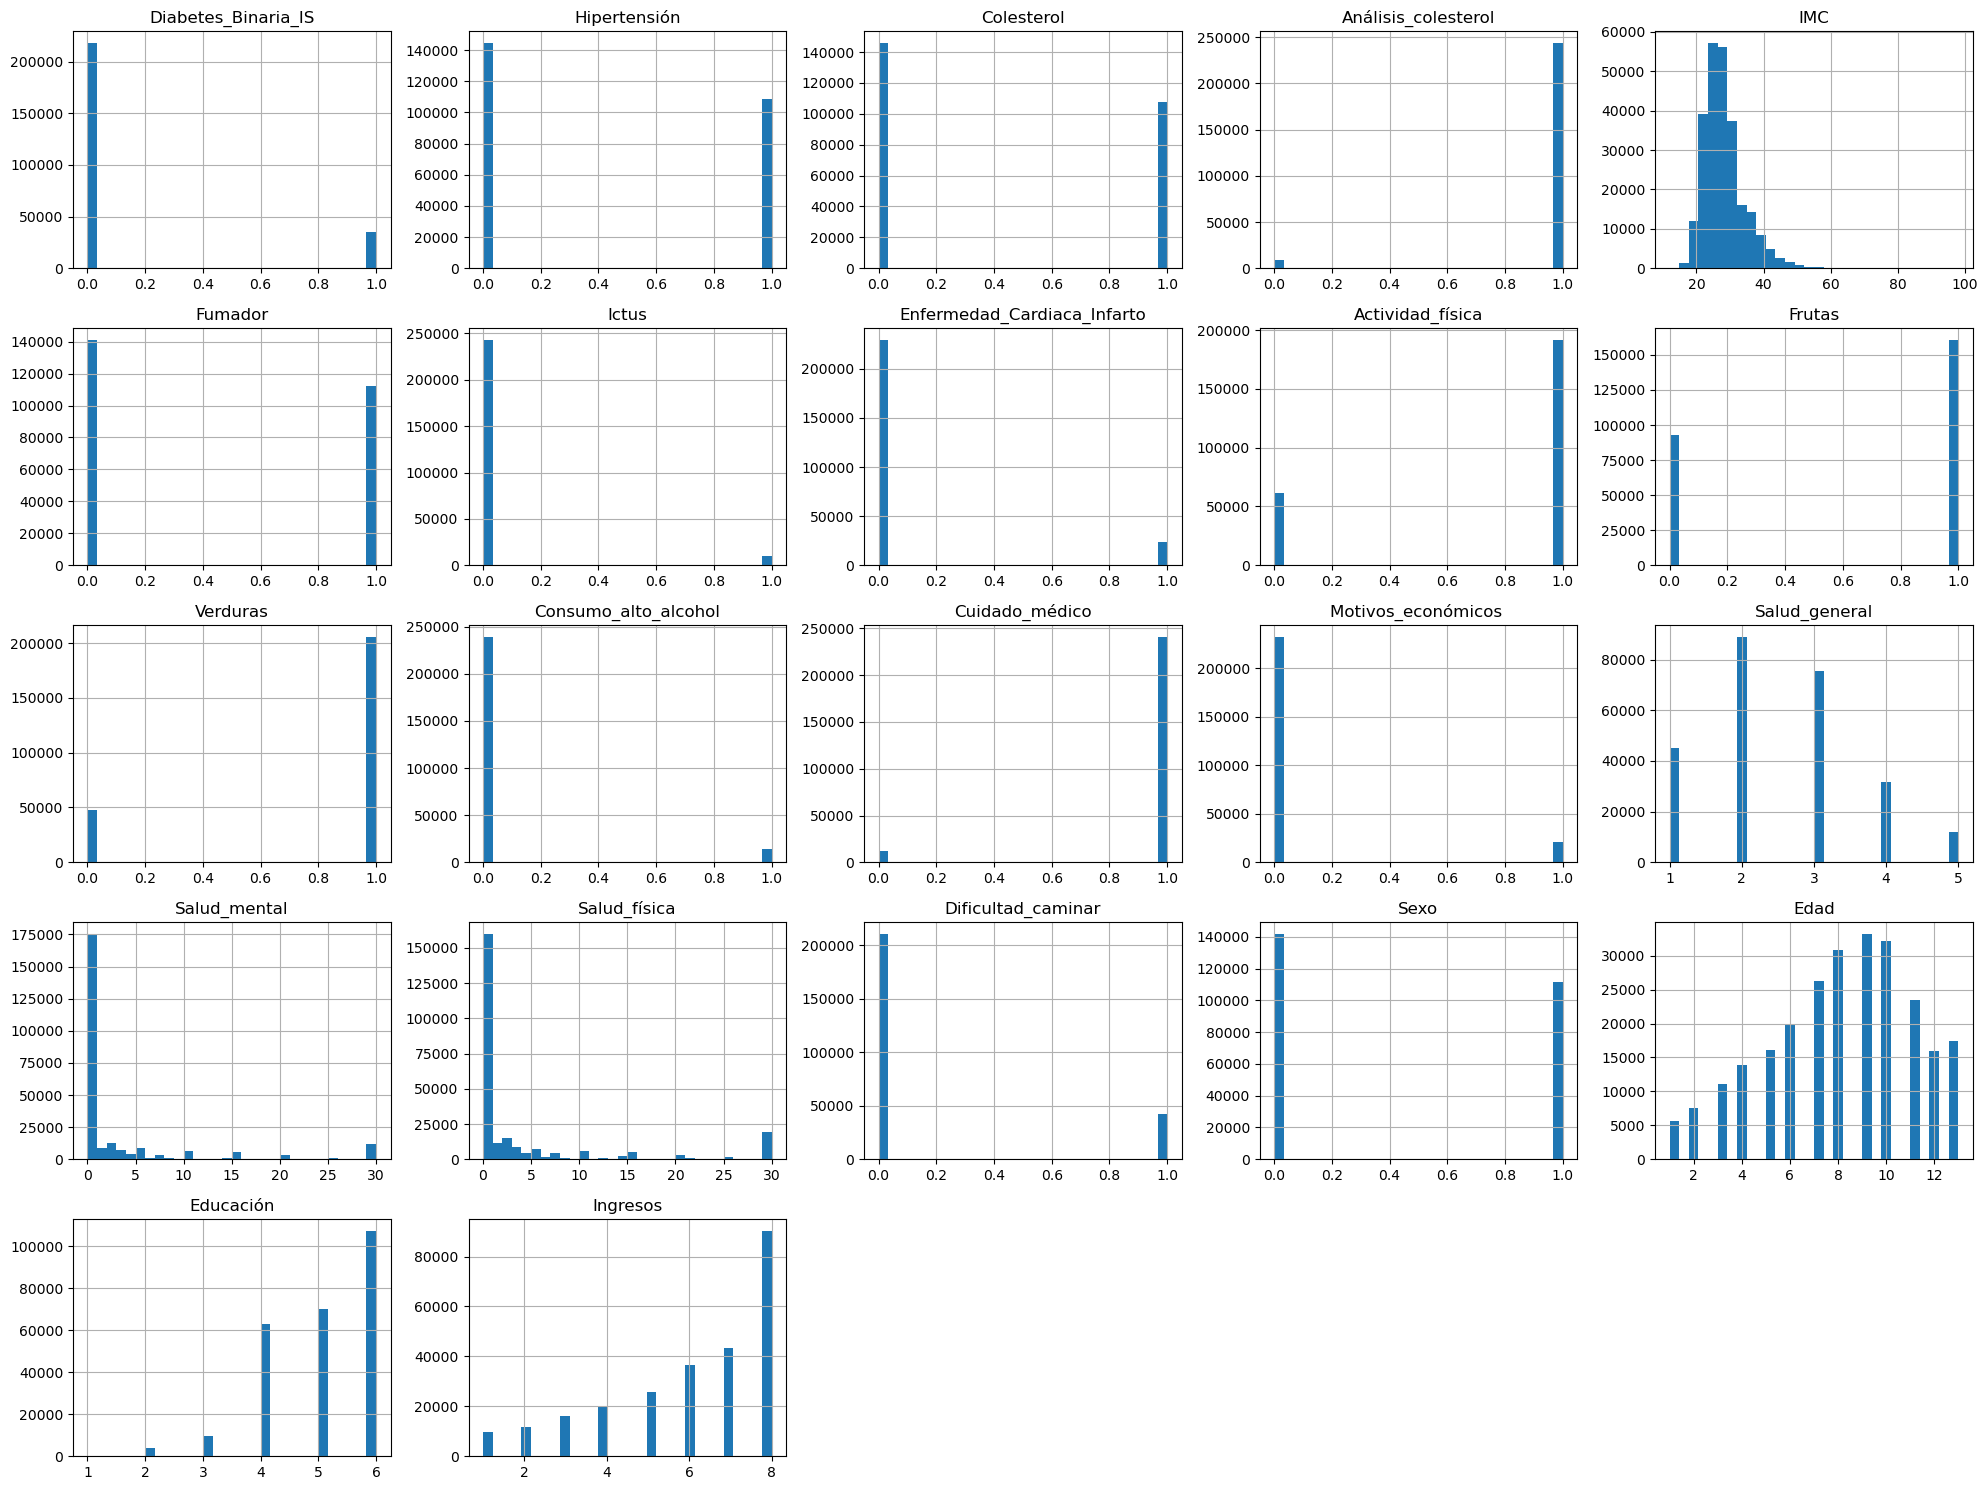

In [68]:
binary_health_indicators.hist(bins = 30, figsize = (20, 15))
plt.tight_layout()
plt.show()

### 3.01.04 Gráfica de las columnas de **Diabetes** de los tres dataframes.

- He creado un dataframe tomando como base la columna de diabetes para poder graficarla. En un cuarto plot, eliminando el axis, he añadido los datos de cada columna.

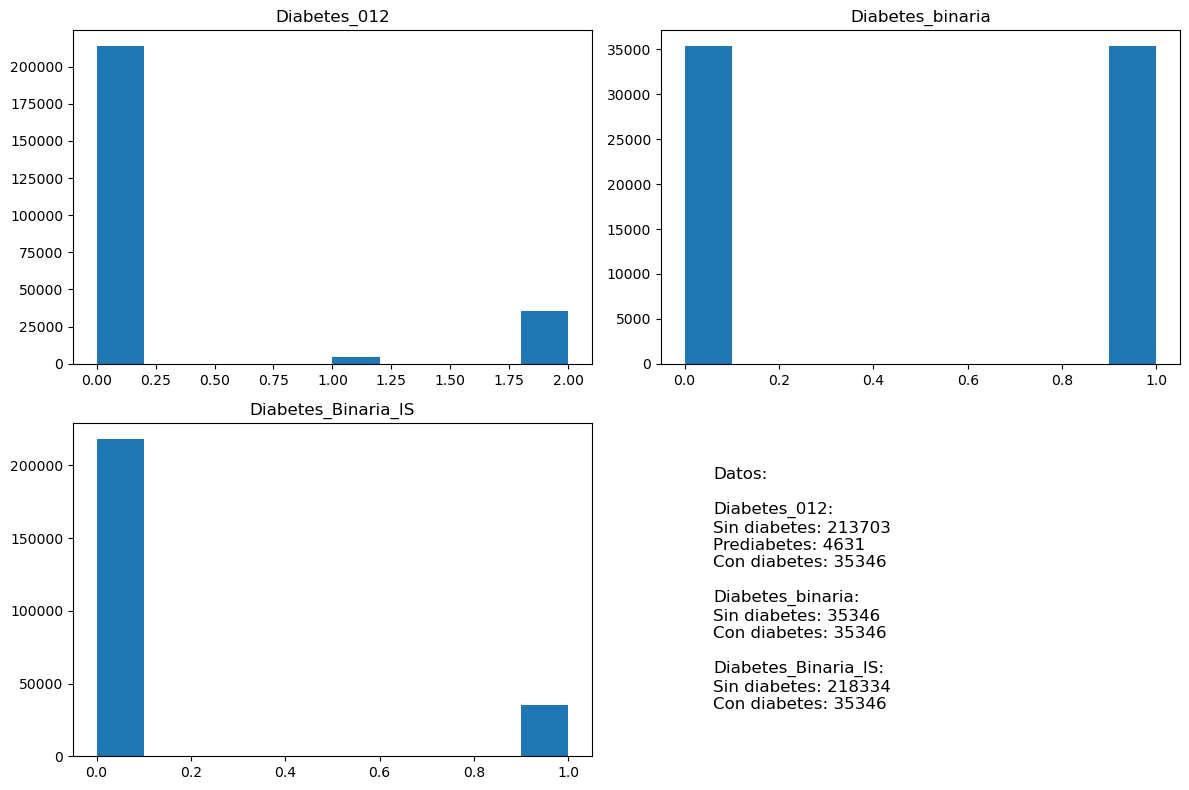

In [69]:
union_diabetes = pd.DataFrame(
    {
        'Diabetes_012': diabetes_012['Diabetes'],
        'Diabetes_binaria': binary_5050['Diabetes_binaria'],
        'Diabetes_Binaria_IS': binary_health_indicators['Diabetes_Binaria_IS']
    }
)

fig, axes = plt.subplots(2, 2, figsize = (12, 8))

union_diabetes['Diabetes_012'].plot(kind = 'hist', bins = 10, ax = axes[0, 0], title = 'Diabetes_012', ylabel = '')
union_diabetes['Diabetes_binaria'].plot(kind = 'hist', bins = 10, ax = axes[0, 1], title = 'Diabetes_binaria', ylabel = '')
union_diabetes['Diabetes_Binaria_IS'].plot(kind = 'hist', bins = 10, ax = axes[1, 0], title = 'Diabetes_Binaria_IS', ylabel = '')

# cuadrícula de texto informativo
axes[1, 1].axis('off')
texto_info = f"""Datos:

Diabetes_012:
Sin diabetes: {union_diabetes['Diabetes_012'].value_counts()[0]}
Prediabetes: {union_diabetes['Diabetes_012'].value_counts()[1]}
Con diabetes: {union_diabetes['Diabetes_012'].value_counts()[2]}

Diabetes_binaria:
Sin diabetes: {union_diabetes['Diabetes_binaria'].value_counts()[0]}
Con diabetes: {union_diabetes['Diabetes_binaria'].value_counts()[1]}

Diabetes_Binaria_IS:
Sin diabetes: {union_diabetes['Diabetes_Binaria_IS'].value_counts()[0]}
Con diabetes: {union_diabetes['Diabetes_Binaria_IS'].value_counts()[1]}"""

axes[1, 1].text(0.1, 0.5, texto_info, fontsize = 12, verticalalignment = 'center')

plt.tight_layout()
plt.show()

#### Distribucion de la clase diabetes.
- Gráfica para mostrar la distribución de la diabetes en los tres dataframes. Cada color muestra visualmente los datos de información de cada clase. El segmento azul representa los datos del dataframe **diabetes_012**. El segmento naranja representa los datos del dataframe **binary_5050**. El segmento verde representa los datos del dataframe **binary_health_indicators**.


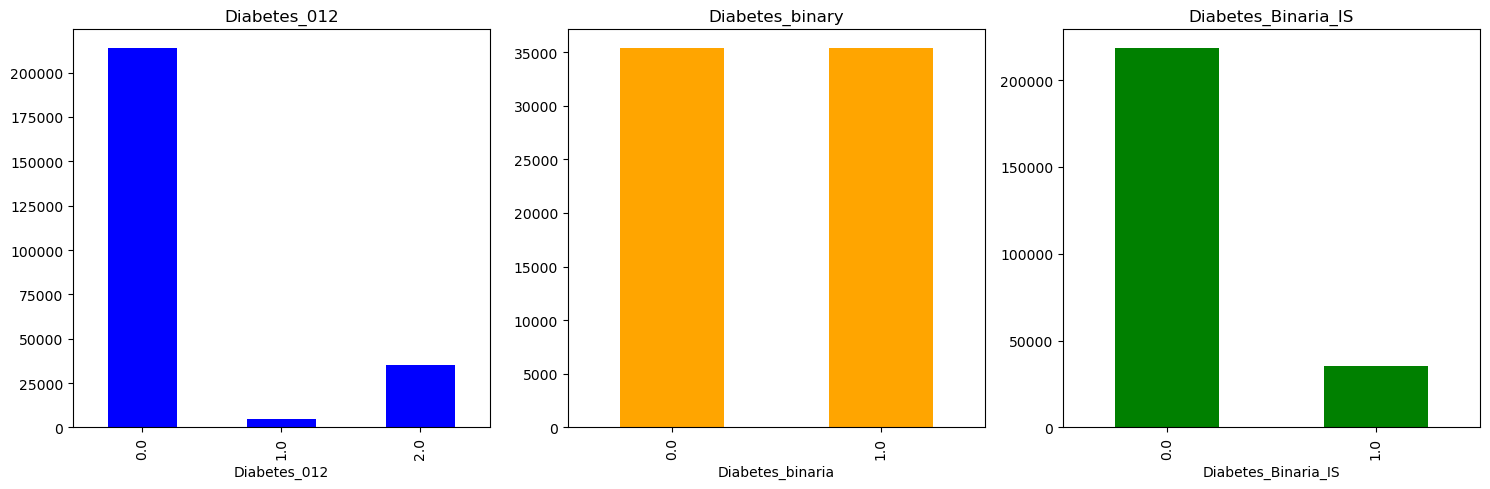

In [71]:
fig, axes = plt.subplots(1, 3, figsize = (15, 5))

union_diabetes['Diabetes_012'].value_counts().sort_index().plot(kind = 'bar', ax = axes[0], color = 'blue', title = 'Diabetes_012')
union_diabetes['Diabetes_binaria'].value_counts().sort_index().plot(kind = 'bar', ax = axes[1], color = 'orange', title = 'Diabetes_binary')
union_diabetes['Diabetes_Binaria_IS'].value_counts().sort_index().plot(kind = 'bar', ax = axes[2], color = 'green', title = 'Diabetes_Binaria_IS')

plt.tight_layout()
plt.show()

####
- Con esta gráfica, se muestra cuan balanceados se encuentran los dataframes.